In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Car-details-v3.csv')

In [4]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [5]:
df.shape

(8128, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [7]:
# remove kmpl from mileage and convert it into float type from object type
df['mileage'] = df['mileage'].apply(lambda x: float(x.split()[0]) if type(x)==str else np.nan)
df['mileage'] = df['mileage'].astype("float")

In [8]:
# remove CC from engine variable 
df['engine'] = df['engine'].apply(lambda x: x.replace("CC","") if type(x)==str else np.nan)

In [9]:
# remove bhp from max_power and convert it into float type from object type
df['max_power'] = df['max_power'].apply(lambda x : x.split()[0] if type(x)==str else np.nan )

In [10]:
# check missing values percentage in each column
df.isnull().mean().round(4).mul(100).sort_values(ascending=False).head()

torque       2.73
mileage      2.72
engine       2.72
seats        2.72
max_power    2.65
dtype: float64

In [11]:
# As seats is categorical column, let's first convert it to categorical from float
print("Before converting dtype: " + str(df.seats.dtype))
df.seats = df.seats.astype('category')
print("After converting dtype: " + str(df.seats.dtype))

Before converting dtype: float64
After converting dtype: category


In [12]:
df.seats.value_counts()

5.0     6254
7.0     1120
8.0      236
4.0      133
9.0       80
6.0       62
10.0      19
2.0        2
14.0       1
Name: seats, dtype: int64

In [13]:
df.torque

0                  190Nm@ 2000rpm
1             250Nm@ 1500-2500rpm
2           12.7@ 2,700(kgm@ rpm)
3        22.4 kgm at 1750-2750rpm
4           11.5@ 4,500(kgm@ rpm)
                  ...            
8123             113.7Nm@ 4000rpm
8124    24@ 1,900-2,750(kgm@ rpm)
8125               190Nm@ 2000rpm
8126          140Nm@ 1800-3000rpm
8127          140Nm@ 1800-3000rpm
Name: torque, Length: 8128, dtype: object

In [14]:
# we will drop the torque as it doesn' have proper format
df.drop(["torque"],axis=1,inplace=True)

In [15]:
# check missing values percentage in each column
df.isnull().mean().round(4).mul(100).sort_values(ascending=False).head()

mileage      2.72
engine       2.72
seats        2.72
max_power    2.65
name         0.00
dtype: float64

In [16]:
df[df["mileage"].isnull() & df["engine"].isnull() & df["seats"].isnull()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
13,Maruti Swift 1.3 VXi,2007,200000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
31,Fiat Palio 1.2 ELX,2003,70000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
78,Tata Indica DLS,2003,50000,70000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN
87,Maruti Swift VDI BSIV W ABS,2015,475000,78000,Diesel,Dealer,Manual,First Owner,NaN,NaN,NaN,NaN
119,Maruti Swift VDI BSIV,2010,300000,120000,Diesel,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7846,Toyota Qualis Fleet A3,2000,200000,100000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN
7996,Hyundai Santro LS zipPlus,2000,140000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
8009,Hyundai Santro Xing XS eRLX Euro III,2006,145000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN
8068,Ford Figo Aspire Facelift,2017,580000,165000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN


In [17]:
df.dropna(inplace=True)

In [18]:
df.shape

(7907, 12)

In [19]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.2,5.0


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7907 entries, 0 to 8127
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   name           7907 non-null   object  
 1   year           7907 non-null   int64   
 2   selling_price  7907 non-null   int64   
 3   km_driven      7907 non-null   int64   
 4   fuel           7907 non-null   object  
 5   seller_type    7907 non-null   object  
 6   transmission   7907 non-null   object  
 7   owner          7907 non-null   object  
 8   mileage        7907 non-null   float64 
 9   engine         7907 non-null   object  
 10  max_power      7907 non-null   object  
 11  seats          7907 non-null   category
dtypes: category(1), float64(1), int64(3), object(7)
memory usage: 749.4+ KB


In [21]:
df[df['max_power'].str.contains('bhp')]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
4933,Maruti Omni CNG,2000,80000,100000,CNG,Individual,Manual,Second Owner,10.9,796,bhp,8.0


In [22]:
# we have one row containing only bhp with no value in it, lets drop it
df = df[df['max_power'].str.contains('bhp') == False]

In [23]:
# convert from object type to their respective types
df["engine"] = df["engine"].astype(int)
df["max_power"] = df["max_power"].astype(float)

In [24]:
df["fuel"].value_counts()

Diesel    4299
Petrol    3520
CNG         52
LPG         35
Name: fuel, dtype: int64

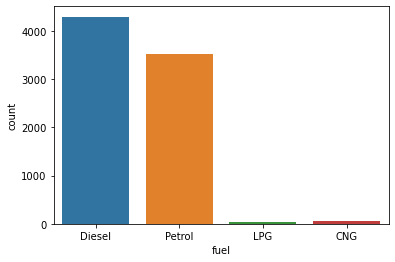

In [25]:
sns.countplot(x='fuel', data=df)
plt.show()

In [26]:
df["seller_type"].value_counts()

Individual          6563
Dealer              1107
Trustmark Dealer     236
Name: seller_type, dtype: int64

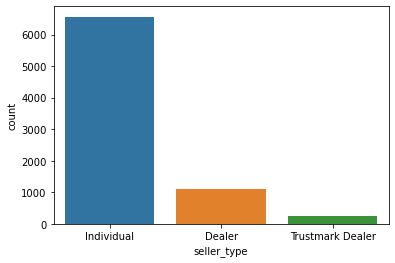

In [27]:
sns.countplot(x='seller_type', data=df)
plt.show()

In [28]:
df["transmission"].value_counts()

Manual       6865
Automatic    1041
Name: transmission, dtype: int64

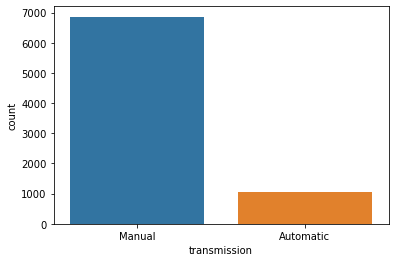

In [29]:
sns.countplot(x='transmission', data=df)
plt.show()

In [30]:
df["owner"].value_counts()

First Owner             5215
Second Owner            2016
Third Owner              510
Fourth & Above Owner     160
Test Drive Car             5
Name: owner, dtype: int64

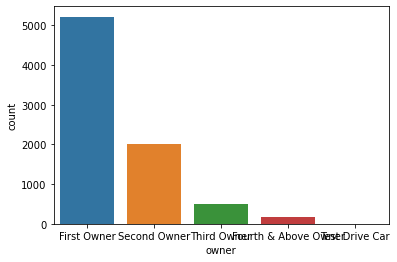

In [31]:
sns.countplot(x='owner', data=df)
plt.show()

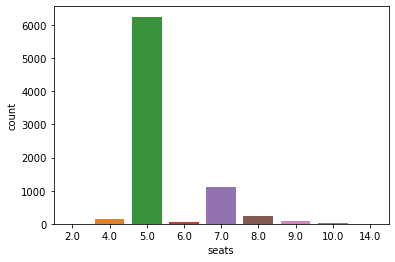

In [32]:
sns.countplot(x='seats', data=df)
plt.show()

<AxesSubplot:xlabel='mileage'>

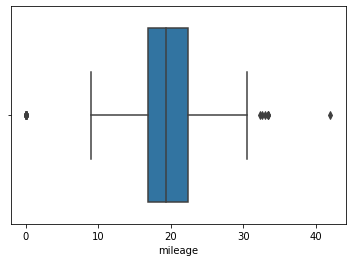

In [33]:
sns.boxplot(x=df['mileage'])

In [34]:
df[df["mileage"]==0]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
644,Tata Indica Vista Aura Safire Anniversary Edition,2009,135000,28900,Petrol,Individual,Manual,Second Owner,0.0,1172,65.00,5.0
785,Hyundai Santro Xing GL,2009,120000,90000,Petrol,Individual,Manual,Second Owner,0.0,1086,62.00,5.0
1649,Hyundai Santro Xing GL,2008,105000,128000,Petrol,Individual,Manual,First Owner,0.0,1086,62.00,5.0
1676,Mercedes-Benz M-Class ML 350 4Matic,2011,1700000,110000,Diesel,Individual,Automatic,Third Owner,0.0,2987,165.00,5.0
2137,Land Rover Freelander 2 TD4 HSE,2013,1650000,64788,Diesel,Dealer,Automatic,First Owner,0.0,2179,115.00,5.0
2366,Hyundai Santro Xing (Non-AC),2010,110000,80000,Petrol,Individual,Manual,Second Owner,0.0,1086,62.10,5.0
2725,Hyundai Santro Xing (Non-AC),2013,184000,15000,Petrol,Individual,Manual,First Owner,0.0,1086,62.10,5.0
4527,Mercedes-Benz M-Class ML 350 4Matic,2011,1700000,110000,Diesel,Individual,Automatic,Third Owner,0.0,2987,165.00,5.0
5276,Hyundai Santro Xing GL,2008,175000,40000,Petrol,Individual,Manual,First Owner,0.0,1086,62.00,5.0
5843,Volkswagen Polo GT TSI BSIV,2014,574000,28080,Petrol,Dealer,Automatic,First Owner,0.0,1197,103.25,5.0


In [35]:
# drop ows having 0 mileage
df = df[df["mileage"]!=0]

<AxesSubplot:xlabel='engine'>

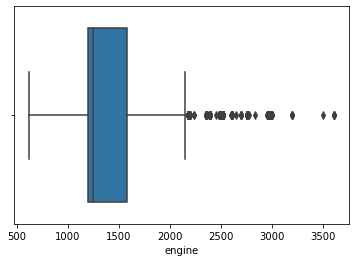

In [36]:
sns.boxplot(x=df['engine'])

In [37]:
df[df["engine"]>3500]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
134,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604,280.0,5.0
1564,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604,280.0,5.0
1860,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604,280.0,5.0
3239,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604,280.0,5.0
5248,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604,280.0,5.0
7703,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.5,3604,280.0,5.0


In [38]:
df = df.drop_duplicates()

In [39]:
df[df["engine"]>3000]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats
134,Jeep Wrangler 2016-2019 3.6 4X4,2017,4100000,17000,Petrol,Individual,Automatic,First Owner,9.50,3604,280.0,5.0
1530,Ford Endeavour 3.2 Titanium AT 4X4,2018,3250000,12000,Diesel,Individual,Automatic,First Owner,10.91,3198,197.0,7.0
1923,Ford Endeavour 3.2 Titanium AT 4X4,2016,2280000,120000,Diesel,Individual,Automatic,Second Owner,10.91,3198,197.0,7.0
3214,Ford Endeavour 3.2 Titanium AT 4X4,2016,2100000,80000,Diesel,Individual,Automatic,First Owner,10.91,3198,197.0,7.0
5962,Mercedes-Benz E-Class E350 Petrol,2009,1000000,80000,Petrol,Individual,Automatic,Third Owner,10.93,3498,272.0,5.0
6468,Ford Endeavour 3.2 Titanium AT 4X4,2018,3200000,35000,Diesel,Individual,Automatic,First Owner,10.91,3198,197.0,7.0


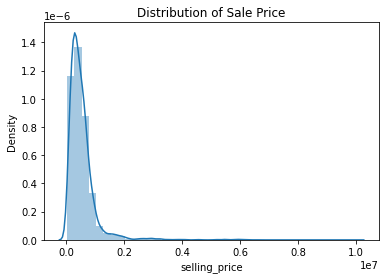

In [40]:
sns.distplot(df["selling_price"], hist=True, kde=True, bins=40).set_title('Distribution of Sale Price')
plt.show()

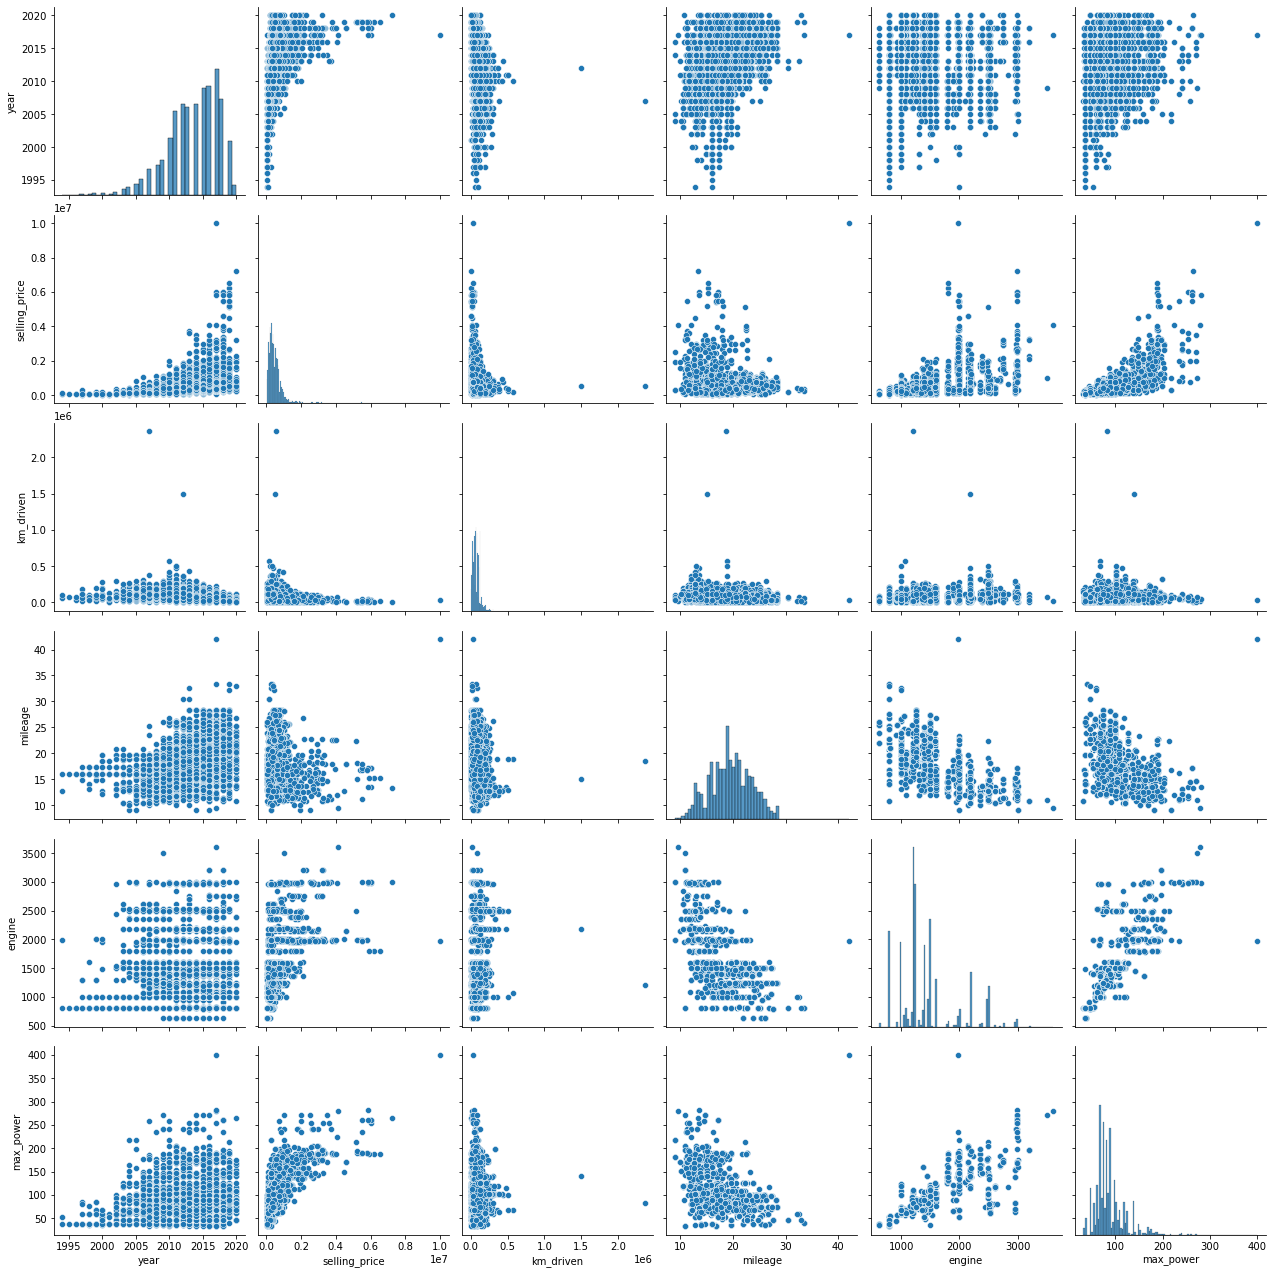

In [41]:
sns.pairplot(df, size = 3)
plt.show()

In [42]:
# let's extact how many years old the car is from year column and drop year column

df["old"] = 2022-df["year"]
df.drop(["year"],axis=1,inplace=True)

In [43]:
df.head()

,name,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,old
0,Maruti Swift Dzire VDI,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,5.0,8
1,Skoda Rapid 1.5 TDI Ambition,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,5.0,8
2,Honda City 2017-2020 EXi,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,5.0,16
3,Hyundai i20 Sportz Diesel,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,5.0,12
4,Maruti Swift VXI BSIII,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,5.0,15


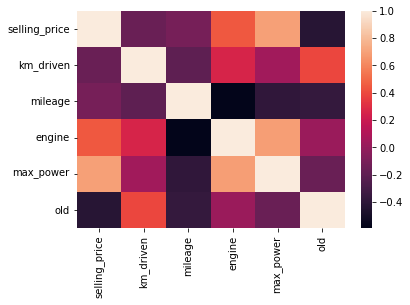

In [44]:
sns.heatmap(df.corr())
plt.show()

In [45]:
# lets drop car name as it is text 

df.drop(["name"],axis=1,inplace=True)

In [46]:
# split the data into X and y

y = df.pop("selling_price")
X = df

In [47]:
# split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

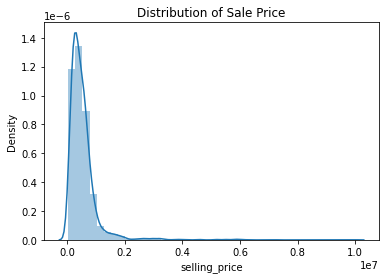

In [48]:
sns.distplot(y_train, hist=True, kde=True, bins=40).set_title('Distribution of Sale Price')
plt.show()

In [49]:
# apply log transformation on y_train
y_train = np.log(y_train)

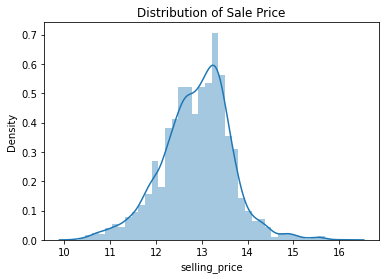

In [50]:
sns.distplot(y_train, hist=True, kde=True, bins=40).set_title('Distribution of Sale Price')
plt.show()

In [51]:
# select categorical data and apply get_dummies function on them
categorical_df = X_train.select_dtypes(include=['object',"category"])
dummies = pd.get_dummies(categorical_df, drop_first=True)

# drop categories for which we created dummy variables
X_train = X_train.drop(list(categorical_df.columns), axis=1)

# concat both dummy vars df and original df
X_train = pd.concat([X_train,dummies], axis=1)

In [52]:
# Apply min max scaling to bring down the values to range from 0-1
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns = X_train.columns,index=X_train.index)
X_train.head()

,km_driven,mileage,engine,max_power,old,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,...,owner_Test Drive Car,owner_Third Owner,seats_4.0,seats_5.0,seats_6.0,seats_7.0,seats_8.0,seats_9.0,seats_10.0,seats_14.0
4868,0.025418,0.133333,0.392617,0.251089,0.461538,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5967,0.016945,0.416364,0.057718,0.039488,0.192308,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2512,0.050837,0.333333,0.260067,0.095861,0.384615,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6869,0.002118,0.490000,0.058725,0.055828,0.115385,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4556,0.025418,0.451515,0.000000,0.012745,0.192308,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
reg = LinearRegression() 
reg.fit(X_train,y_train)

LinearRegression()

In [54]:
y_pred_train = reg.predict(X_train)

In [55]:
# lets see the metrics

r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)


mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)

0.8497821934534971
401.6445664119136
0.08562024438540047


In [56]:
# Apply same steps on test data as performed for training data

# apply log transformation on y_train
y_test = np.log(y_test)
# select categorical data and apply get_dummies function on them
categorical_df = X_test.select_dtypes(include=['object',"category"])
dummies = pd.get_dummies(categorical_df, drop_first=True)

# drop categories for which we created dummy variables
X_test = X_test.drop(list(categorical_df.columns), axis=1)

# concat both dummy vars df and original df
X_test = pd.concat([X_test,dummies], axis=1)

# Apply min max scaling to bring down the values to range from 0-1
X_test = pd.DataFrame(scaler.transform(X_test),columns = X_test.columns,index=X_test.index)
X_test.head()

,km_driven,mileage,engine,max_power,old,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Individual,seller_type_Trustmark Dealer,...,owner_Test Drive Car,owner_Third Owner,seats_4.0,seats_5.0,seats_6.0,seats_7.0,seats_8.0,seats_9.0,seats_10.0,seats_14.0
2844,0.044483,0.436364,0.209396,0.112200,0.269231,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1691,0.002118,0.352424,0.192617,0.093137,0.076923,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2939,0.004236,0.193030,0.191946,0.109477,0.115385,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
675,0.033891,0.306061,0.192282,0.133987,0.153846,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3701,0.029655,0.290909,0.192282,0.144336,0.307692,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
y_pred_test = reg.predict(X_test)

In [58]:
# lets see the metrics
r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)

rss1_lr = np.sum(np.square(y_test - y_pred_test))
print(rss1_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)

0.8321875624037561
182.59514424861294
0.09079818212263199


3.498942058422152e-16

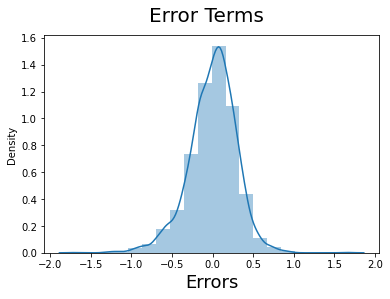

In [59]:
# residual analysis


# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_pred_train), bins = 20)
# Plot heading
fig.suptitle('Error Terms', fontsize = 20)    
# Give the X-label
plt.xlabel('Errors', fontsize = 18)  

residuals = y_train - y_pred_train
np.mean(residuals)

Text(0, 0.5, 'error terms')

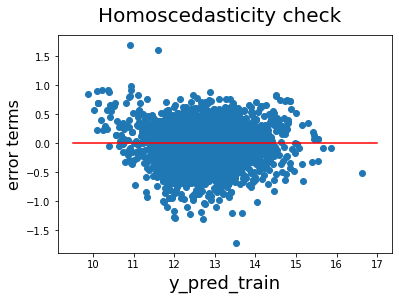

In [60]:
fig = plt.figure()
plt.scatter(y_pred_train,residuals)
fig.suptitle('Homoscedasticity check', fontsize=20) 
p = sns.lineplot([9.5,17],[0,0.0],color='red')
plt.xlabel('y_pred_train', fontsize=18)   
plt.ylabel('error terms', fontsize=16) 